# Introduction #

We will explore two widely used methods for developing recommendation systems: Popularity-based Recommendation and Collaborative Filtering Recommendation. These techniques enable us to deliver personalized book suggestions to users based on their individual interests and preferences.

## Popularity-based Recommendation 

Popularity-based Recommendation is a straightforward yet effective approach that recommends books based on their overall popularity or popularity within a specific user group. It suggests books that have garnered high ratings or have been frequently purchased or read by a large number of users. This method is suitable when providing general recommendations to a broad audience.

## Collaborative Filtering Recommendation

Collaborative Filtering Recommendation is a more sophisticated technique that taps into the collective knowledge of a community of users. It identifies similarities in user behavior and preferences to generate personalized recommendations. Collaborative Filtering seeks patterns among users who share similar tastes, suggesting books that have been liked or highly rated by users with comparable interests to the target user.

In this notebook, we will implement both Popularity-based Recommendation and Collaborative Filtering Recommendation techniques to offer a diverse and tailored set of book recommendations.

In [42]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
#reading datasets
books=pd.read_csv('./input/Books.csv')
ratings=pd.read_csv('./input/Ratings.csv')
users=pd.read_csv('./input/Users.csv')

c:\Users\hp\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Understanding **books** dataset

In [44]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [45]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [ ]:
books.info()

In [46]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [82]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [47]:
users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [83]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [48]:
# Check size and missing values of 'books' DataFrame
print("\nShape of 'books' DataFrame:", books.shape)
print("Missing values in 'books' DataFrame:")
print(books.isnull().sum())

# Check shape and missing values of 'ratings' DataFrame
print("\nShape of 'ratings' DataFrame:", ratings.shape)
print("\nMissing values in 'ratings' DataFrame:")
print(ratings.isnull().sum())


# Check  shape and missing values of 'users' DataFrame
print("\nShape of 'users' DataFrame:", users.shape)
print("\nMissing values in 'users' DataFrame:")
print(users.isnull().sum())



Shape of 'books' DataFrame: (271360, 8)
Missing values in 'books' DataFrame:
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Shape of 'ratings' DataFrame: (1149780, 3)

Missing values in 'ratings' DataFrame:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Shape of 'users' DataFrame: (278858, 3)

Missing values in 'users' DataFrame:
User-ID          0
Location         0
Age         110762
dtype: int64


As observed, the "age" column contains numerous missing values. However, since age doesn't carry significant weight in our recommendation system, and ratings are the primary feature for our recommendations, we are considering the removal of the "age" column.

In [49]:
# Count duplicated rows in 'books' DataFrame
books_duplicates_count = books.duplicated().sum()
print("Duplicated rows count in 'books' DataFrame:", books_duplicates_count)

# Count duplicated rows in 'ratings' DataFrame
ratings_duplicates_count = ratings.duplicated().sum()
print("Duplicated rows count in 'ratings' DataFrame:", ratings_duplicates_count)

# Count duplicated rows in 'users' DataFrame
users_duplicates_count = users.duplicated().sum()
print("Duplicated rows count in 'users' DataFrame:", users_duplicates_count)

Duplicated rows count in 'books' DataFrame: 0
Duplicated rows count in 'ratings' DataFrame: 0
Duplicated rows count in 'users' DataFrame: 0


# EDA 
Extensive Data analysis

### Top 10 publishers with the most books ###

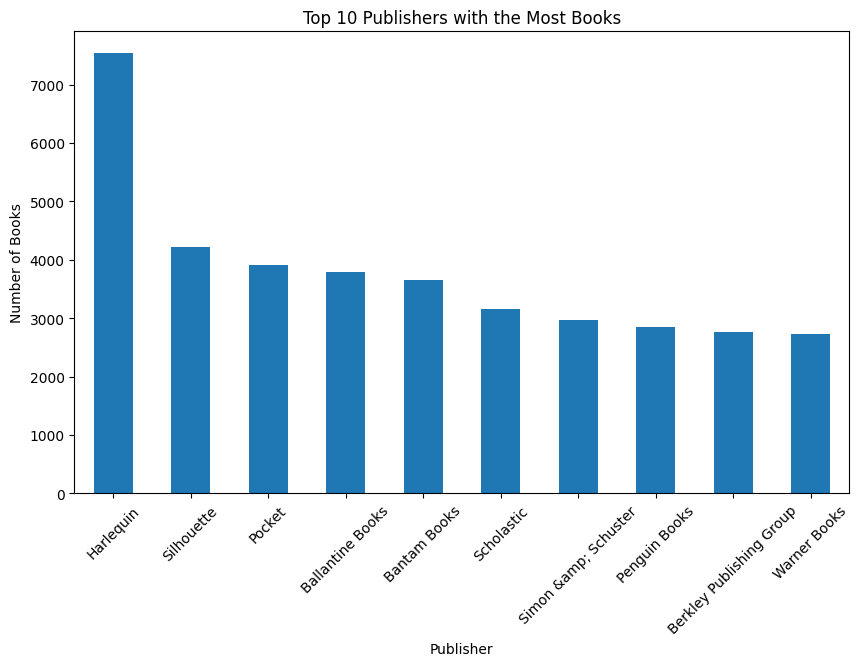

In [50]:

top_publishers = books['Publisher'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_publishers.plot(kind='bar')
plt.title('Top 10 Publishers with the Most Books')
plt.xlabel('Publisher')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()


### Top 10 Authors with the most books ###

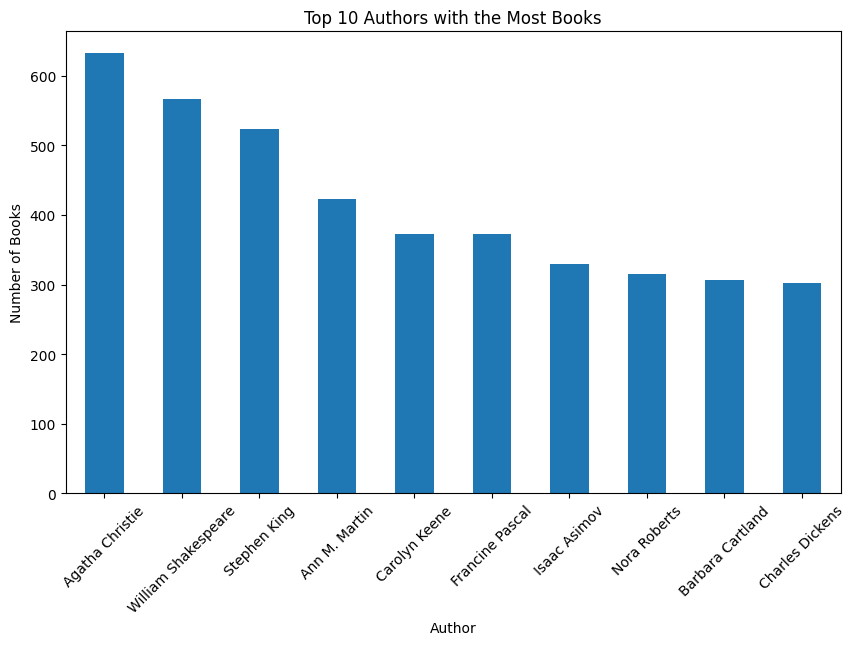

In [51]:
# top 10 Authors with the most books
top_authors = books['Book-Author'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_authors.plot(kind='bar')
plt.title('Top 10 Authors with the Most Books')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()

### Top 10 years when most books got published ###

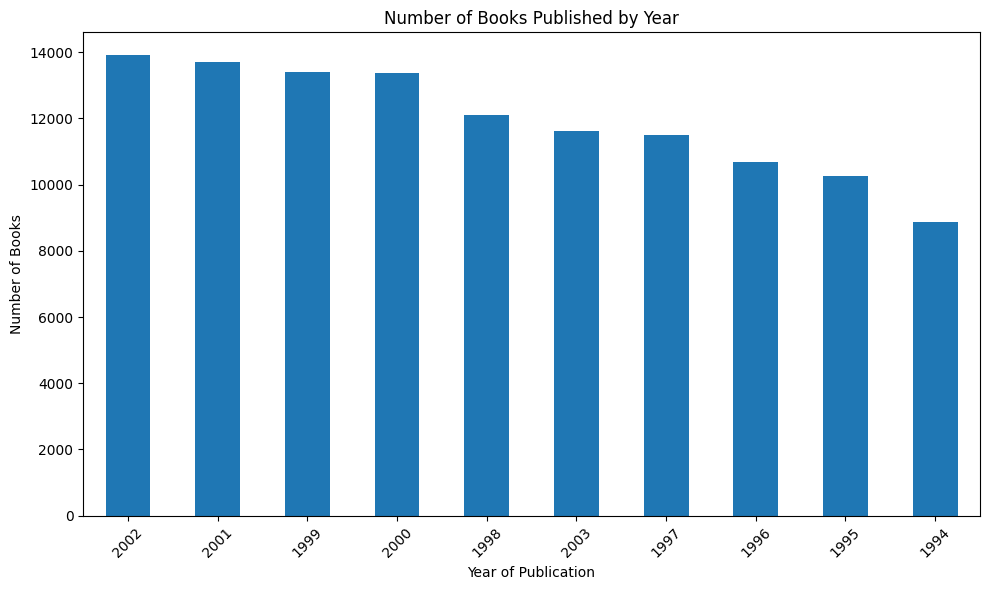

In [52]:
# Group the data by Year-Of-Publication and count the number of books in each year
year_counts = books['Year-Of-Publication'].value_counts().sort_values(ascending=False)


# Top 10 years with the most books published
top_10_years = year_counts.head(10)

# Convert years to integers
top_10_years.index = top_10_years.index.astype(int)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_10_years.plot(kind='bar')
plt.title('Number of Books Published by Year')
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



### Top 10 popular books ###

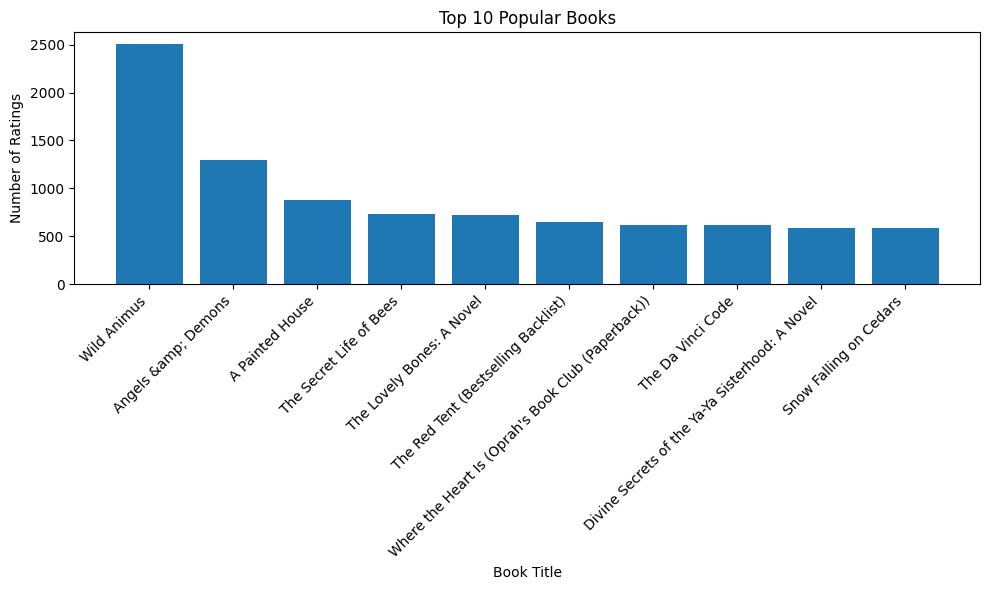

In [53]:
#Top 10 popular books
# Merge the books and ratings dataframes on the common ISBN column
merged_df = pd.merge(books, ratings, on='ISBN')

# Calculate the count of ratings for each book
book_ratings_count = merged_df['ISBN'].value_counts().head(10)

# Get the top 10 popular books based on ratings count
top_10_popular_books = books[books['ISBN'].isin(book_ratings_count.index)]

# Create a bar chart to visualize the top 10 popular books
plt.figure(figsize=(10, 6))
plt.bar(top_10_popular_books['Book-Title'], book_ratings_count)
plt.title('Top 10 Popular Books')
plt.xlabel('Book Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Popularity based recommendation

Picture yourself in a library, surrounded by an abundance of books lining the shelves. Faced with the dilemma of choosing your next read, you notice a particular book that's generating a lot of buzz – people are borrowing it, talking about it, and describing it as a captivating and enjoyable experience.

Intrigued by the widespread interest in this book, you decide to follow the crowd. The reasoning is simple: if so many readers are expressing their love for it, perhaps it's worth exploring.

This is the essence of popularity-based book recommendations. The system suggests books that have gained popularity and are widely read among a large audience. It considers factors such as high demand, frequent borrowings, and positive reviews from numerous readers.

The underlying concept is that if a book has garnered significant attention and acclaim from a diverse audience, there's a good chance it will be a rewarding read for you too. It's akin to joining a literary trend and delving into a book that has captivated the interest and enjoyment of many others.

We will present a compilation of the **top 50 books determined by their average ratings**. Nonetheless, it's crucial to acknowledge that certain books might have acquired high ratings with only a limited number of votes, potentially not truly reflecting their overall quality. To mitigate this, our selection will exclusively encompass books that have amassed a minimum of **250 reviews**. This criterion aims to enhance the reliability and representativeness of the ratings, offering a more accurate depiction of the book's popularity and quality.

In [54]:
#we are going to used only Books and rating dataset for our popularity
#Lets merged it two datasets 
print("before merged")
print("ratings shape:",ratings.shape)
print("Books shape:",books.shape)
books_ratings=ratings.merge(books,on='ISBN')
print("after merged:",books_ratings.shape)

before merged
ratings shape: (1149780, 3)
Books shape: (271360, 8)
after merged: (1031136, 10)


#### Now, lets calculate average rating of each books and take only those books where total ratings >250(Assumption) ####

Below code takes a dataframe with book ratings, groups it by book titles, counts the number of ratings for each book, and creates a new dataframe with the book titles and their respective counts of ratings. It then renames the column representing the count of ratings to 'num_ratings' for clarity.

In [55]:
# Group the 'books_ratings' dataframe by the 'Book-Title' column and count the number of occurrences of 'Book-Rating'
num_rating_df = books_ratings.groupby('Book-Title').count()['Book-Rating'].reset_index()

# Rename the 'Book-Rating' column to 'num_ratings' in the 'num_rating_df' dataframe
num_rating_df.rename(columns={'Book-Rating':'num_ratings'}, inplace=True)

In [56]:
num_rating_df.head(2)

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1


#### Now we have number of rating for each book,Lets figure out average rating for each book ####

Below code takes a dataframe with book ratings and names, groups it by book titles, calculates the average rating for each book, and creates a new dataframe with the book titles and their respective average ratings. It then renames the column representing the average rating to 'avg_rating' for clarity.

In [57]:
# Group the 'ratings_with_name' dataframe by the 'Book-Title' column and calculate the mean of 'Book-Rating'
avg_rating_df = books_ratings.groupby('Book-Title').mean()['Book-Rating'].reset_index()
# Rename the 'Book-Rating' column to 'avg_rating' in the 'avg_rating_df' dataframe
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'}, inplace=True)

avg_rating_df.head(2)

,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00


#### Now,Lets merge both the dataframe ***num_rating_df*** and ***avg_rating_df*** and filter only those books where total ratings >250 ####

In [58]:
# Merge the 'num_rating_df' and 'avg_rating_df' DataFrames on the 'Book-Title' column
popular_df = num_rating_df.merge(avg_rating_df, on='Book-Title')
popular_df.head(2)

,Book-Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00


#### Now as we can see we have number of ratings and average ratings w.r.to each movie 
#### We want to keep only those movies which has total rating >250 ####

Below code filters the 'popular_df' dataframe to include only books with a minimum of 250 ratings, sorts them based on their average ratings in descending order, and finally selects the top 50 books with the highest average ratings. This helps us to  identify the most popular books with high ratings among those that have received a significant number of ratings.

In [59]:
# Filter and select the top 50 popular items with a minimum of 250 ratings, based on average rating
popular_df = popular_df[popular_df['num_ratings'] >= 250].sort_values('avg_rating', ascending=False).head(50)

In [60]:
popular_df.head(2)

,Book-Title,num_ratings,avg_rating
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.824289


### We have our top most 50 Popular books based on their average ratings. ###

# Collaborative filtering

Collaborative filtering analyzes the preferences and behaviors of different users, identifies patterns, and makes recommendations based on similarities between users. Instead of relying solely on your individual preferences, collaborative filtering takes into account the preferences of other users who have similar tastes to improve the accuracy of its recommendations.

Imagine you're at a bookstore and you're trying to decide which book to buy. The store owner suggests books based on what other customers with similar tastes have enjoyed.

The store owner keeps track of what books people buy and likes to see if there are any patterns. They notice that customers who have liked similar books as you also tend to enjoy a specific book that you haven't read yet.

Using this information, the store owner recommends that book to you because they think you'll probably like it too. They're using the collective knowledge of other people who have similar reading preferences to help you find books you might enjoy.

It's like having a knowledgeable friend who knows what books you might like based on what other people with similar tastes have enjoyed. The store owner is using this "wisdom of the crowd" to make personalized recommendations just for you.

collaborative filtering uses the "wisdom of the crowd" to suggest items (in this case, books) that you might like based on the preferences of similar users. It's like getting personalized recommendations from people who have similar reading interests to yours.

To build a recommender system based on how users rated books, we have two datasets: one containing information about books and another containing user ratings. We will merge these datasets to create a new dataset.

However, to focus on experienced readers, we will only consider users who have rated at least **200 books**. This ensures that we are taking into account the opinions of users who have a substantial history of reading and rating books.

Additionally, we will only include books that have received a minimum of **50 ratings**. By doing so, we prioritize books that have been reviewed by a significant number of readers, indicating a higher level of popularity or attention.


In [61]:
#Lets merged it two datasets 
print("before merged")
print("ratings shape:",ratings.shape)
print("Books shape:",books.shape)
books_ratings_collab=ratings.merge(books,on='ISBN')
print("after merged:",books_ratings_collab.shape)

before merged
ratings shape: (1149780, 3)
Books shape: (271360, 8)
after merged: (1031136, 10)


Now lets take only those user whoi had rate atleast 200 books

In [62]:
books_ratings_collab.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


Now we will keep only those users who have rated minimum 200 reviews for a book

In [63]:
books_ratings_collab.groupby('User-ID')['Book-Title'].count()

User-ID
2          1
8         17
9          3
10         1
12         1
          ..
278846     1
278849     4
278851    23
278852     1
278854     8
Name: Book-Title, Length: 92106, dtype: int64

#### We have total 92106 users who have rated the books,Lets find out how many of them rated at least 200 books ####

Lets find out users who have rated more than 200 books

In [64]:
# Group the 'ratings_with_name' DataFrame by 'User-ID' and count the occurrences of 'Book-Rating' for each user
# The result is a Series with the 'User-ID' as the index and the count of ratings as the values
user_ratings_count = books_ratings_collab.groupby('User-ID').count()['Book-Rating']

# Create a boolean condition by comparing each count with 200, resulting in a Series of True/False values
# True indicates that the user has rated more than 200 books, while False indicates they haven't
is_experienced_reader = user_ratings_count > 200

# Filter the 'user_ratings_count' Series by the True values, resulting in only the indices (User-IDs) of users who have rated more than 200 books
experienced_readers = user_ratings_count[is_experienced_reader].index



In [65]:
# Filter the 'ratings_with_name' DataFrame to include only ratings from experienced readers
filtered_rating = books_ratings_collab[books_ratings_collab['User-ID'].isin(experienced_readers)]
filtered_rating.shape

(474007, 10)

#### We have found a large group of 474,007 users who are avid readers and have rated at least 200 books in our dataset

Now lets include books that have received a minimum of 50 ratings. 

In [66]:
# Group the 'filtered_rating' DataFrame by 'Book-Title' and count the occurrences of 'Book-Rating' for each book
# The result is a Series with the 'Book-Title' as the index and the count of ratings as the values
book_ratings_count = filtered_rating.groupby('Book-Title').count()['Book-Rating']

# Create a boolean condition by comparing each count with 50, resulting in a Series of True/False values
# True indicates that the book has received at least 50 ratings, while False indicates it hasn't
is_popular_book = book_ratings_count >= 50

# Filter the 'book_ratings_count' Series by the True values, resulting in only the indices (Book-Titles) of popular books
popular_books = book_ratings_count[is_popular_book].index


In [67]:
# Filter the 'filtered_rating' DataFrame to include only ratings for popular books
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(popular_books)]


Now we have experience reader as well as list of books with sufficient number of ratings per each books.

Lets create a table where each row represents a specific book, and each column represents a user. The cells of the table contain the ratings given by the users for the corresponding books. This way, all the ratings for each book and user are neatly organized.
This could be helpful because it allows us to see the ratings given by each user for each book in a structured format. We can easily look up a specific book and see how different users have rated it.

Also,we can easily see how different users have rated books. By identifying users who have similar ratings for certain books, we can find people who have similar preferences. For example, if User A and User B have rated many books similarly, it suggests that they have similar tastes in books.

In [68]:
# Create a pivot table to organize book ratings data
# The pivot table will have books as rows, users as columns, and ratings as the cell values

# Group the 'final_ratings' DataFrame by 'Book-Title' and 'User-ID'
# Calculate the average rating for each combination of book and user
# The resulting table will have books as rows and users as columns

book_ratings_pivot = final_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')


In [69]:
book_ratings_pivot.shape

(706, 810)

we have total 706 books and the ratings given by 810 different users for these books.

In [70]:
book_ratings_pivot.head(2)

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets fill the missing values with zeros, it helps us to ensure that every cell in the table has a value, even if it represents a lack of rating.<br>
This can be useful for subsequent calculations and to maintain consistent data in the table.

In [71]:
# Fill any missing values in the book_ratings_pivot table with zeros
book_ratings_pivot.fillna(0, inplace=True)

Now lets apply  collaborative filtering techniques to make personalized recommendations based on similar user preferences.

Cosine similarity:
https://www.kaggle.com/code/adityaghuse/movie-recommendation-beginner-friendly?cellId=59&cellIds=59&kernelSessionId=136797140

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

In [73]:
# calculates the similarity between vectors using a method called cosine similarity.
#In simpler terms, it takes a vector (a mathematical representation of the movie) and compares it to other vectors representing different movies.
#It calculates how similar these vectors are by measuring the cosine of the angle between them. 
#The resulting similarity values indicate how closely related the movies are based on their vector representations.
#Essentially, it helps to determine how similar two books are by looking at their numerical representations and calculating a similarity score.
similarity_scores = cosine_similarity(book_ratings_pivot)

In [74]:
similarity_scores

array([[1.        , 0.10255025, 0.01220856, ..., 0.12110367, 0.07347567,
        0.04316046],
       [0.10255025, 1.        , 0.2364573 , ..., 0.07446129, 0.16773875,
        0.14263397],
       [0.01220856, 0.2364573 , 1.        , ..., 0.04558758, 0.04938579,
        0.10796119],
       ...,
       [0.12110367, 0.07446129, 0.04558758, ..., 1.        , 0.07085128,
        0.0196177 ],
       [0.07347567, 0.16773875, 0.04938579, ..., 0.07085128, 1.        ,
        0.10602962],
       [0.04316046, 0.14263397, 0.10796119, ..., 0.0196177 , 0.10602962,
        1.        ]])

Now,Lets create a recommend function that takes a book name, finds the index of the book in **book_ratings_pivot** table,<br>
Identifies similar books based on their similarity scores, retrieves their details from the dataset, and returns a list of recommended books with their titles and author.

In [75]:
def recommend(book_name):
    # Find the index of the input book name in the pivot table
    index = np.where(book_ratings_pivot.index == book_name)[0][0]

    # Retrieve the similarity scores of the input book with other books,
    # sort them in descending order, and select the top 4 similar items
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x: x[1], reverse=True)[1:10]

    # Initialize an empty list to store recommended book information
    data = []

    # Iterate through each similar item
    for i in similar_items:
        item = []

        # Fetch the relevant book details (title, author, image URL) from the 'books' dataset
        temp_df = books[books['Book-Title'] == book_ratings_pivot.index[i[0]]]

        # Append the book details to the 'item' list
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))

        # Append the 'item' list to the 'data' list
        data.append(item)

    # Return the 'data' list containing information about the recommended books
    return data


In [76]:
recommend('I Know This Much Is True')

[['Sea Glass: A Novel', 'Anita Shreve'],
 ['Blue Diary', 'Alice Hoffman'],
 ["Where the Heart Is (Oprah's Book Club (Paperback))", 'Billie Letts'],
 ['Saint Maybe', 'ANNE TYLER'],
 ['Here on Earth', 'Alice Hoffman'],
 ['The English Patient', 'Michael Ondaatje'],
 ["The Plains of Passage (Earth's Children (Paperback))", 'JEAN M. AUEL'],
 ["Drowning Ruth (Oprah's Book Club)", 'CHRISTINA SCHWARZ'],
 ["She's Come Undone (Oprah's Book Club (Paperback))", 'Wally Lamb']]

In [77]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% for training and 20% for testing)
train_data, test_data = train_test_split(final_ratings, test_size=0.2, random_state=42)


In [78]:
train_matrix = train_data.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)
test_matrix = test_data.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)


In [79]:
train_similarity_scores = cosine_similarity(train_matrix)


In [80]:
def predict(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

test_prediction = predict(test_matrix.values, train_similarity_scores)


In [81]:
from sklearn.metrics import mean_squared_error

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

# Calculate RMSE for the test set
rmse_score = rmse(test_prediction, test_matrix.values)
print("RMSE Score:", rmse_score)


RMSE Score: 7.770658429615624
